In [1]:
import os
import glob
import json

import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import psutil
psutil.virtual_memory().available

14916665344

In [6]:
DATA_PATH = '../data/test_cnn_data'

In [7]:
import zipfile
with zipfile.ZipFile('../data/data.zip', 'r') as zip_ref:
    zip_ref.extractall('../data/')

In [8]:
num_images = len(list(glob.glob(os.path.join(DATA_PATH, '*/*/*.png'))))
"total images: {}".format(num_images)

'total images: 138'

In [9]:
train_dir = os.path.join(DATA_PATH,'train')
val_dir = os.path.join(DATA_PATH,'val')

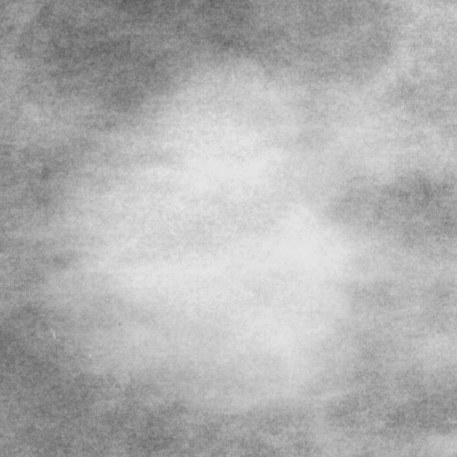

In [10]:
Image.open(list(glob.glob(train_dir+'/*/*.png'))[0])

In [11]:
CLASSES = np.array([item for item in os.listdir(train_dir)])
"classes: {}".format(CLASSES)

"classes: ['tumor' 'normal_tissue']"

In [12]:
print('Train:')
for cls in CLASSES:
    print(f"number of images belonging to {cls} class: {len(os.listdir(os.path.join(train_dir,cls)))}")
    
print('\nValidation:')
for cls in CLASSES:
    print(f"number of images belonging to {cls} class: {len(os.listdir(os.path.join(val_dir,cls)))}")

Train:
number of images belonging to tumor class: 63
number of images belonging to normal_tissue class: 63

Validation:
number of images belonging to tumor class: 6
number of images belonging to normal_tissue class: 6


In [13]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
def get_train_dataset(batch_size):
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(300, 300),
        batch_size=batch_size,
        class_mode='binary')
    return train_generator

In [15]:
def get_val_dataset(batch_size):
    val_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(300, 300),
        batch_size=batch_size,
        class_mode='binary')
    return val_generator

In [16]:
def build_and_compile_cnn():
    model = Sequential([
#         layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
#         layers.Conv2D(256, 3, padding='same', activation='relu'),
#         layers.Conv2D(512, 3, padding='same', activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

In [17]:
per_worker_batch_size = 10
train_generator = get_train_dataset(per_worker_batch_size)
validation_generator = get_val_dataset(2)
single_worker_model = build_and_compile_cnn()
single_worker_model.fit(train_generator, validation_data=validation_generator, epochs=3)

Found 126 images belonging to 2 classes.
Found 12 images belonging to 2 classes.


ResourceExhaustedError: OOM when allocating tensor with shape[11520000,128] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu [Op:Mul]

In [15]:
os.environ['TF_CONFIG'] = json.dumps({
    'cluster': {
        'worker': ["localhost:12345", "localhost:23456"]
    },
    'task': {'type': 'worker', 'index': 0}
})

In [14]:
strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/device:CPU:0',)
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CollectiveCommunication.AUTO


In [ ]:
num_workers = 4
per_worker_batch_size = 10

# Here the batch size scales up by number of workers since 
# `tf.data.Dataset.batch` expects the global batch size. Previously we used 64, 
# and now this becomes 128.
global_batch_size = per_worker_batch_size * num_workers
train_generator = get_train_dataset(per_worker_batch_size)
validation_generator = get_val_dataset(2)

with strategy.scope():
  # Model building/compiling need to be within `strategy.scope()`.
  multi_worker_model = build_and_compile_cnn()

# Keras' `model.fit()` trains the model with specified number of epochs and
# number of steps per epoch. Note that the numbers here are for demonstration
# purposes only and may not sufficiently produce a model with good quality.
multi_worker_model.fit(train_generator, validation_data=validation_generator, epochs=3)

Found 126 images belonging to 2 classes.
Found 12 images belonging to 2 classes.
